# This notebook is for the Fair-Shapely experiment

In [ ]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [ ]:
from src.data.unified_dataloader import load_dataset

a, processed_census_income_kdd = load_dataset('census_income_kdd')

In [ ]:
processed_census_income_kdd.head(3)

### 3. Split label/unlabel data, split train/test data.

In [ ]:
'''census income kdd dataset'''
sampled_data = processed_census_income_kdd.sample(frac=0.1, random_state=25)  # 2% of the data
df = sampled_data.copy()
X = df.drop('class', axis=1)
y = df['class']
X.shape

In [ ]:
from src.evaluation.five_fold_cross_validation import evaluate_model
model = XGBClassifier()
evaluate_model(model=model, X_train=X, y_train=y, num_folds=5, dataset_name='census_income')

### 4. read saved_csv file and make plots

In [1]:
def extract_original_values(fold):
    original_DR = fold.loc[0,'new_DR']
    original_DP = fold.loc[0,'new_DP']
    original_EO = fold.loc[0,'new_EO']
    original_PQP = fold.loc[0,'new_PQP']
    return original_DR, original_DP, original_EO, original_PQP

In [2]:
import pandas as pd
fold1 = pd.read_csv('saved_results/census_income/1-fold_results.csv')
fold2 = pd.read_csv('saved_results/census_income/2-fold_results.csv')
fold3 = pd.read_csv('saved_results/census_income/3-fold_results.csv')
fold4 = pd.read_csv('saved_results/census_income/4-fold_results.csv')
fold5 = pd.read_csv('saved_results/census_income/5-fold_results.csv')

fold1_original_DR, fold1_original_DP, fold1_original_EO, fold1_original_PQP = extract_original_values(fold1)
fold2_original_DR, fold2_original_DP, fold2_original_EO, fold2_original_PQP = extract_original_values(fold2)
fold3_original_DR, fold3_original_DP, fold3_original_EO, fold3_original_PQP = extract_original_values(fold3)
fold4_original_DR, fold4_original_DP, fold4_original_EO, fold4_original_PQP = extract_original_values(fold4)
fold5_original_DR, fold5_original_DP, fold5_original_EO, fold5_original_PQP = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

folds = [fold1, fold2, fold3, fold4, fold5]
original_drs = [fold1_original_DR, fold2_original_DR, fold3_original_DR, fold4_original_DR, fold5_original_DR]
original_dps = [fold1_original_DP, fold2_original_DP, fold3_original_DP, fold4_original_DP, fold5_original_DP]  
original_eos = [fold1_original_EO, fold2_original_EO, fold3_original_EO, fold4_original_EO, fold5_original_EO]
original_pqps = [fold1_original_PQP, fold2_original_PQP, fold3_original_PQP, fold4_original_PQP, fold5_original_PQP]


#### 4.1 直接plot_results

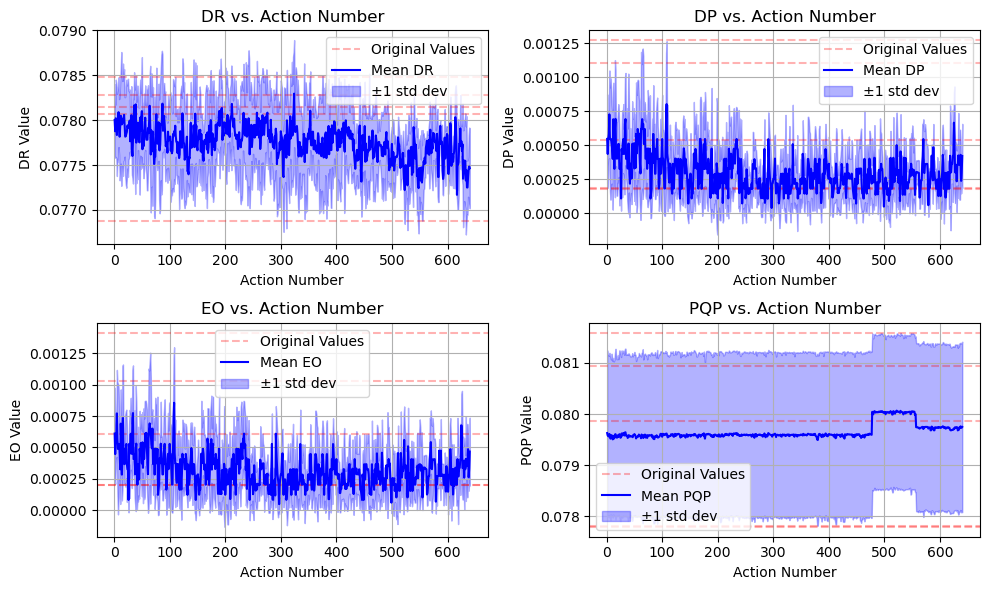

In [3]:
from src.visualization.visualization2 import plot_results

# 调用函数
plot_results(
    folds=folds,
    original_DR=original_drs, 
    original_DP=original_dps, 
    original_EO=original_eos, 
    original_PQP=original_pqps,
    stop_when_no_data=3,
    min_action=1,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='b',
    red_alpha=0.3  # 红线透明度
)

#### 4.2 画图每个fold相对自己original value的提升

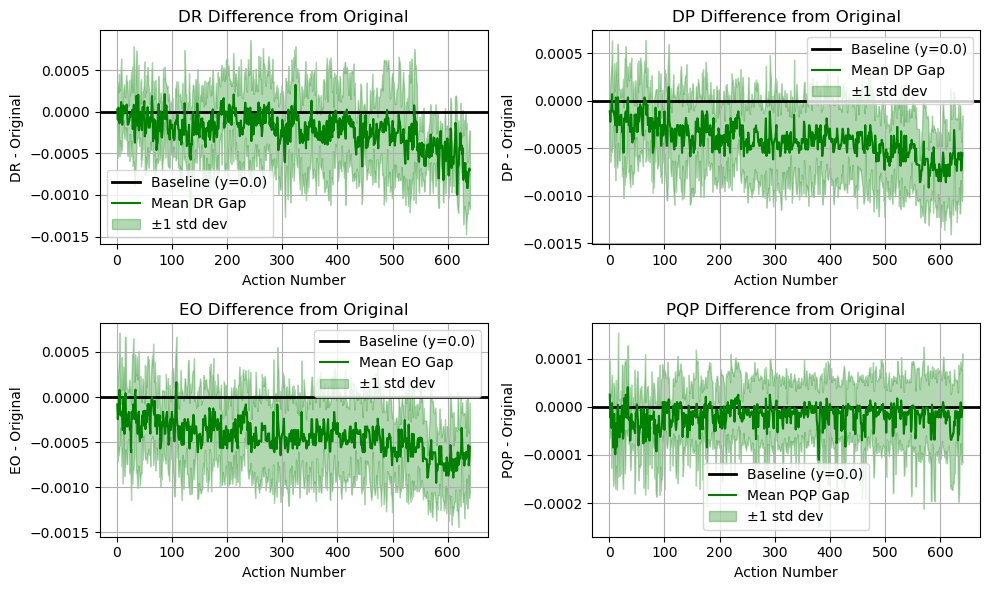

In [4]:
from src.visualization.visualization1 import plot_fairness_improvement


plot_fairness_improvement(
    folds=folds,
    original_DR=original_drs,
    original_DP=original_dps,
    original_EO=original_eos,
    original_PQP=original_pqps,
    stop_when_no_data=3,  # 当有 3 个 fold 无数据时停止
    min_action=1,
    baseline=0.0,
    figsize=(10, 6),
    fill_alpha=0.3,
    fill_color='g'
)